
# **Modelado con XGBoost**
#### **1. Importación de Librerías y Carga del Dataset**
#### **1.1 Importación de librerías**

In [25]:
import numpy as np
import pandas as pd
import os
import pickle
import time
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier  
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    f1_score,
    roc_curve, 
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
    average_precision_score
)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import optuna
from prettytable import PrettyTable

# Configuración para visualizaciones

df = pd.read_csv('../../../data/clean/online_shoppers_clean.csv')

# Información básica del dataset
print(f"Dimensiones del dataset: {df.shape}")
print("\nPrimeras 5 filas:")
print(df.head())

# Distribución de la variable objetivo
print("\nDistribución de Revenue:")
print(df['Revenue'].value_counts())
print(df['Revenue'].value_counts(normalize=True) * 100)

# Comprobación de VisitorType
print("\nDistribución de VisitorType:")
print(df['VisitorType'].value_counts())


Dimensiones del dataset: (12205, 18)

Primeras 5 filas:
   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1 

#### **2. Preprocesado de datos**
#### **2.1 Filtración de Registros y Creación de Transformaciones**

In [26]:
# Crear una copia del dataframe para no modificar el original
print("Iniciando preprocesado de datos...")
X = df.copy()

# Filtrar registros - excluir VisitorType='Other'
print(f"Registros antes de filtración: {X.shape[0]}")
X = X[X['VisitorType'] != 'Other']
print(f"Registros después de filtrar 'Other': {X.shape[0]}")

# 1. Crear transformaciones logarítmicas
print("\nCreando transformaciones logarítmicas...")
X['Administrative_Duration_Log'] = np.log1p(X['Administrative_Duration'])
X['Informational_Duration_Log'] = np.log1p(X['Informational_Duration'])
X['ProductRelated_Duration_Log'] = np.log1p(X['ProductRelated_Duration'])

# 2. Crear variable binaria para PageValues
X['PageValues_NonZero'] = (X['PageValues'] > 0).astype(int)

# 3. Crear variables derivadas
X['TotalPages'] = X['Administrative'] + X['Informational'] + X['ProductRelated']
X['TotalDuration'] = X['Administrative_Duration'] + X['Informational_Duration'] + X['ProductRelated_Duration']

# Mostrar las nuevas columnas creadas
print("\nNuevas columnas creadas:")
new_columns = [
    'Administrative_Duration_Log', 
    'Informational_Duration_Log', 
    'ProductRelated_Duration_Log',
    'PageValues_NonZero',
    'TotalPages',
    'TotalDuration'
]
display(X[new_columns].head())

# Mostrar estadísticas descriptivas de las nuevas columnas
print("\nEstadísticas descriptivas de las nuevas columnas:")
display(X[new_columns].describe())

#### **2.2 Codificación de Variables Categóricas**
# 4. Crear variables dummy para Month (todos los meses)
print("\nCreando variables dummy para Month...")
month_dummies = pd.get_dummies(X['Month'], prefix='Month', drop_first=True)
X = pd.concat([X, month_dummies], axis=1)

# 5. Crear variables dummy para VisitorType (excluyendo 'Other')
print("Creando variables dummy para VisitorType...")
# Asegurarse de que solo tenemos los tipos de visitantes que queremos
X = X[X['VisitorType'].isin(['New_Visitor', 'Returning_Visitor'])]

# Crear variables dummy SIN eliminar la primera categoría
visitor_dummies = pd.get_dummies(X['VisitorType'], prefix='VisitorType', drop_first=False)
X = pd.concat([X, visitor_dummies], axis=1)

# Mostrar las variables dummy creadas
print("\nVariables dummy de Month:")
display(X[[col for col in X.columns if col.startswith('Month_')]].head())

print("\nVariables dummy de VisitorType:")
display(X[[col for col in X.columns if col.startswith('VisitorType_')]].head())

# Seleccionar variables finales para el modelo
selected_features = [
    # Variables originales clave
    'PageValues', 'ExitRates', 'BounceRates', 'Weekend',
    
    # Variables transformadas
    'Administrative_Duration_Log', 'Informational_Duration_Log', 'ProductRelated_Duration_Log',
    
    # Variables derivadas
    'PageValues_NonZero', 'TotalPages', 'TotalDuration'
]

# Añadir todas las columnas dummy de meses
month_columns = [col for col in X.columns if col.startswith('Month_')]
selected_features.extend(month_columns)

# Añadir AMBAS columnas de tipo de visitante
visitor_columns = [col for col in X.columns if col.startswith('VisitorType_')]
selected_features.extend(visitor_columns)

# Mostrar las variables seleccionadas
print("\nVariables seleccionadas para el modelo:")
print(selected_features)
print(f"Total de variables seleccionadas: {len(selected_features)}")

# Mostrar las primeras filas de las características seleccionadas
print("\nPrimeras filas de las características seleccionadas:")
display(X[selected_features].head())

#### **2.3. Exportación del preprocesador**
# Crear un diccionario con la información de preprocesado
preprocessor = {
    'selected_features': selected_features,
    'month_columns': month_columns,
    'visitor_columns': visitor_columns,
    'preprocesado_info': {
        'excluir_visitantes': ['Other'],
        'transformaciones_log': ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration'],
        'variables_derivadas': {
            'TotalPages': 'Administrative + Informational + ProductRelated',
            'TotalDuration': 'Administrative_Duration + Informational_Duration + ProductRelated_Duration',
            'PageValues_NonZero': 'PageValues > 0'
        }
    }
}

# Guardar el preprocesador
preproc_path = '../xgboost/pkl_exports/xgboost_preprocessor.pkl'
with open(preproc_path, 'wb') as f:
    pickle.dump(preprocessor, f)

print(f"\nPreprocesador guardado en: {preproc_path}")

# Preparar X e y finales para el modelo
X_final = X[selected_features]
y_final = X['Revenue'].astype(int)

print(f"\nDimensiones de X después del preprocesado: {X_final.shape}")
print(f"Distribución de la variable objetivo: {np.bincount(y_final)}")

Iniciando preprocesado de datos...
Registros antes de filtración: 12205
Registros después de filtrar 'Other': 12124

Creando transformaciones logarítmicas...

Nuevas columnas creadas:


,Administrative_Duration_Log,Informational_Duration_Log,ProductRelated_Duration_Log,PageValues_NonZero,TotalPages,TotalDuration
0,0.0,0.0,0.000000,0,1,0.000000
1,0.0,0.0,4.174387,0,2,64.000000
2,0.0,0.0,0.000000,0,1,0.000000
3,0.0,0.0,1.299283,0,2,2.666667
4,0.0,0.0,6.443336,0,10,627.500000



Estadísticas descriptivas de las nuevas columnas:


,Administrative_Duration_Log,Informational_Duration_Log,ProductRelated_Duration_Log,PageValues_NonZero,TotalPages,TotalDuration
count,12124.000000,12124.000000,12124.000000,12124.000000,12124.000000,12124.000000
mean,2.334328,0.856555,6.032613,0.223854,35.027714,1327.775670
std,2.365678,1.826606,1.955224,0.416842,46.701179,2047.135858
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,5.281298,0.000000,9.000000,234.396667
50%,2.335245,0.000000,6.421532,0.000000,20.500000,694.534578
75%,4.564348,0.000000,7.302727,0.000000,42.000000,1651.835951
max,8.131457,7.843996,11.066240,1.000000,746.000000,69921.647230



Creando variables dummy para Month...
Creando variables dummy para VisitorType...

Variables dummy de Month:


,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,False,True,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False



Variables dummy de VisitorType:


,VisitorType_New_Visitor,VisitorType_Returning_Visitor
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True



Variables seleccionadas para el modelo:
['PageValues', 'ExitRates', 'BounceRates', 'Weekend', 'Administrative_Duration_Log', 'Informational_Duration_Log', 'ProductRelated_Duration_Log', 'PageValues_NonZero', 'TotalPages', 'TotalDuration', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'VisitorType_New_Visitor', 'VisitorType_Returning_Visitor']
Total de variables seleccionadas: 21

Primeras filas de las características seleccionadas:


,PageValues,ExitRates,BounceRates,Weekend,Administrative_Duration_Log,Informational_Duration_Log,ProductRelated_Duration_Log,PageValues_NonZero,TotalPages,TotalDuration,...,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Returning_Visitor
0,0.0,0.20,0.20,False,0.0,0.0,0.000000,0,1,0.000000,...,True,False,False,False,False,False,False,False,False,True
1,0.0,0.10,0.00,False,0.0,0.0,4.174387,0,2,64.000000,...,True,False,False,False,False,False,False,False,False,True
2,0.0,0.20,0.20,False,0.0,0.0,0.000000,0,1,0.000000,...,True,False,False,False,False,False,False,False,False,True
3,0.0,0.14,0.05,False,0.0,0.0,1.299283,0,2,2.666667,...,True,False,False,False,False,False,False,False,False,True
4,0.0,0.05,0.02,True,0.0,0.0,6.443336,0,10,627.500000,...,True,False,False,False,False,False,False,False,False,True



Preprocesador guardado en: ../xgboost/pkl_exports/xgboost_preprocessor.pkl

Dimensiones de X después del preprocesado: (12124, 21)
Distribución de la variable objetivo: [10232  1892]


#### **3. Entrenamiento del Modelo**


Forma del conjunto de entrenamiento: (9699, 21)
Forma del conjunto de prueba: (2425, 21)
Distribución de clases en entrenamiento: [8185 1514]
Distribución de clases en prueba: [2047  378]
Forma del conjunto de entrenamiento después de SMOTE: (16370, 21)
Distribución de clases después de SMOTE: [8185 8185]


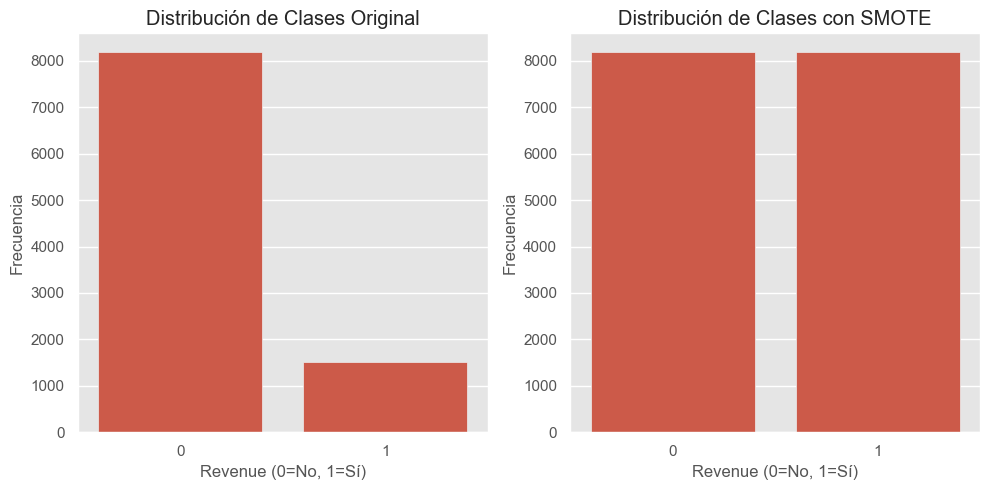


Entrenando modelo XGBoost base...
Modelo base entrenado con éxito.

--- Métricas del Modelo Base ---
Precisión en entrenamiento: 0.9400
F1-score en entrenamiento: 0.9398
Precisión en prueba: 0.8903
F1-score en prueba: 0.6732
AUC-ROC: 0.9300
Diferencia (indicador de overfitting): 0.0496

Evaluando con validación cruzada...


[I 2025-05-08 12:16:00,261] A new study created in memory with name: no-name-eb81af24-108e-40a5-aa5f-9e99c8f556c0
[I 2025-05-08 12:16:00,429] Trial 0 finished with value: 0.6763285024154589 and parameters: {'n_estimators': 157, 'max_depth': 8, 'learning_rate': 0.21478598015064235, 'subsample': 0.8510137781921301, 'colsample_bytree': 0.8513136626016378, 'min_child_weight': 1, 'gamma': 4.387975134352404, 'alpha': 4.326571069765391, 'lambda': 2.5874574413072224, 'scale_pos_weight': 1.088416591349175}. Best is trial 0 with value: 0.6763285024154589.


F1-score con validación cruzada (5-fold): 0.6391 (+/- 0.0931)

Informe de clasificación en conjunto de prueba:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      2047
           1       0.63      0.72      0.67       378

    accuracy                           0.89      2425
   macro avg       0.79      0.82      0.80      2425
weighted avg       0.90      0.89      0.89      2425

Modelo base guardado en: ../xgboost/pkl_exports/xgboost_model_base.pkl
Iniciando optimización de hiperparámetros con Optuna...


[I 2025-05-08 12:16:01,135] Trial 1 finished with value: 0.6382536382536382 and parameters: {'n_estimators': 261, 'max_depth': 10, 'learning_rate': 0.11665554052947281, 'subsample': 0.7470386529821639, 'colsample_bytree': 0.8564571077272416, 'min_child_weight': 7, 'gamma': 0.9167374642530884, 'alpha': 2.582727174979387, 'lambda': 4.485699581099697, 'scale_pos_weight': 8.599225989586637}. Best is trial 0 with value: 0.6763285024154589.
[I 2025-05-08 12:16:01,755] Trial 2 finished with value: 0.614115490375802 and parameters: {'n_estimators': 317, 'max_depth': 10, 'learning_rate': 0.02513828215610997, 'subsample': 0.9235859336155372, 'colsample_bytree': 0.5316649205763468, 'min_child_weight': 9, 'gamma': 4.836232071041099, 'alpha': 4.550530479764785, 'lambda': 3.4484893763894595, 'scale_pos_weight': 4.825885622494214}. Best is trial 0 with value: 0.6763285024154589.
[I 2025-05-08 12:16:01,996] Trial 3 finished with value: 0.6736353077816493 and parameters: {'n_estimators': 221, 'max_dept

Optimización completada en 0.50 minutos

Mejores hiperparámetros encontrados:
- n_estimators: 303
- max_depth: 6
- learning_rate: 0.12481876316491919
- subsample: 0.9418931961721914
- colsample_bytree: 0.8214429108383069
- min_child_weight: 1
- gamma: 3.376059881481588
- alpha: 1.6553289298699192
- lambda: 3.721955199557904
- scale_pos_weight: 1.0091988953603657
Mejor F1-score: 0.6902

Importancia de los hiperparámetros:
- scale_pos_weight: 0.7926
- max_depth: 0.0885
- alpha: 0.0689
- lambda: 0.0104
- subsample: 0.0100
- colsample_bytree: 0.0082
- learning_rate: 0.0069
- gamma: 0.0064
- n_estimators: 0.0056
- min_child_weight: 0.0024


C:\Users\Administrator\AppData\Local\Temp\ipykernel_26016\1294222286.py:150: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 1000x600 with 0 Axes>

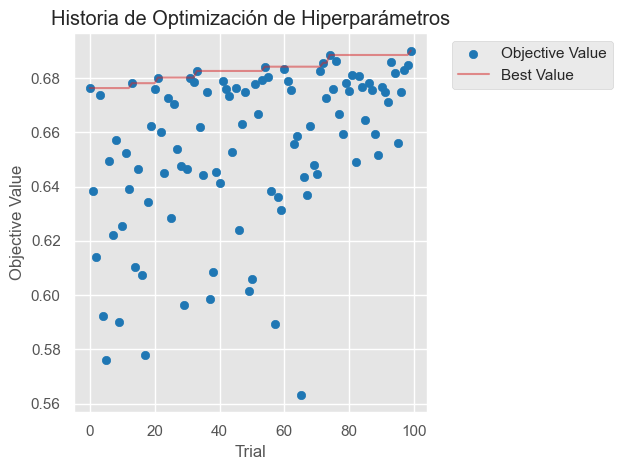

C:\Users\Administrator\AppData\Local\Temp\ipykernel_26016\1294222286.py:157: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Figure size 1000x600 with 0 Axes>

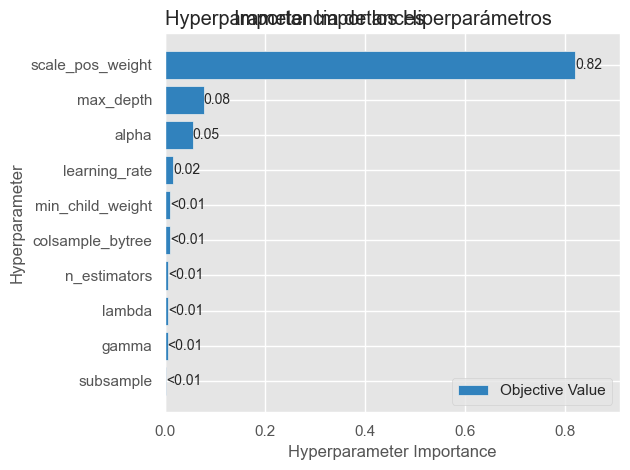


Entrenando modelo optimizado con los mejores hiperparámetros...
Modelo optimizado guardado en: ../xgboost/pkl_exports/xgboost_optimized.pkl


In [27]:
#### **3.1 División en conjuntos de entrenamiento y prueba**
# Preparar X e y finales para el modelo
X_final = X[selected_features]
y_final = X['Revenue'].astype(int)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

print(f"Forma del conjunto de entrenamiento: {X_train.shape}")
print(f"Forma del conjunto de prueba: {X_test.shape}")
print(f"Distribución de clases en entrenamiento: {np.bincount(y_train)}")
print(f"Distribución de clases en prueba: {np.bincount(y_test)}")

#### **3.2 Balanceo de clases con SMOTE**
# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Forma del conjunto de entrenamiento después de SMOTE: {X_train_resampled.shape}")
print(f"Distribución de clases después de SMOTE: {np.bincount(y_train_resampled)}")

# Visualizar la distribución de clases antes y después de SMOTE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Distribución de Clases Original')
plt.xlabel('Revenue (0=No, 1=Sí)')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title('Distribución de Clases con SMOTE')
plt.xlabel('Revenue (0=No, 1=Sí)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

#### **3.3 Entrenamiento del Modelo XGBoost**
# Entrenar el modelo XGBoost con parámetros iniciales
print("\nEntrenando modelo XGBoost base...")
xgb_model_base = XGBClassifier(
    n_estimators=100,              # Número de árboles
    max_depth=5,                  # Profundidad máxima de cada árbol
    learning_rate=0.1,            # Tasa de aprendizaje
    subsample=0.8,                # Fracción de muestras para entrenar cada árbol
    colsample_bytree=0.8,         # Fracción de características para cada árbol
    objective='binary:logistic',  # Objetivo para clasificación binaria
    random_state=42
)

# Entrenar en datos con SMOTE
xgb_model_base.fit(X_train_resampled, y_train_resampled)
print("Modelo base entrenado con éxito.")

# Evaluar el modelo en datos de entrenamiento y prueba
print("\n--- Métricas del Modelo Base ---")
# Entrenamiento
y_train_pred = xgb_model_base.predict(X_train_resampled)
train_accuracy = (y_train_pred == y_train_resampled).mean()
train_f1 = f1_score(y_train_resampled, y_train_pred)

# Prueba
y_test_pred = xgb_model_base.predict(X_test)
test_accuracy = (y_test_pred == y_test).mean()
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, xgb_model_base.predict_proba(X_test)[:, 1])

# Mostrar métricas
print(f"Precisión en entrenamiento: {train_accuracy:.4f}")
print(f"F1-score en entrenamiento: {train_f1:.4f}")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"F1-score en prueba: {test_f1:.4f}")
print(f"AUC-ROC: {test_auc:.4f}")
print(f"Diferencia (indicador de overfitting): {train_accuracy - test_accuracy:.4f}")

# Verificar overfitting con validación cruzada
print("\nEvaluando con validación cruzada...")
cv_scores = cross_val_score(xgb_model_base, X_final, y_final, cv=5, scoring='f1')
print(f"F1-score con validación cruzada (5-fold): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Informe detallado de clasificación
print("\nInforme de clasificación en conjunto de prueba:")
print(classification_report(y_test, y_test_pred))

# Guardar el modelo entrenado
model_path = '../xgboost/pkl_exports/xgboost_model_base.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(xgb_model_base, f)
print(f"Modelo base guardado en: {model_path}")

#### **3.4 Optimización de hiperparámetros con Optuna**
print("Iniciando optimización de hiperparámetros con Optuna...")
start_time = time.time()

def objective(trial):
    # Definir espacio de búsqueda para hiperparámetros de XGBoost
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'alpha': trial.suggest_float('alpha', 0, 5),  # Regularización L1
        'lambda': trial.suggest_float('lambda', 0, 5),  # Regularización L2
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),  # Peso para la clase minoritaria
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'random_state': 42
    }
    
    # Configurar modelo con hiperparámetros sugeridos
    xgb_model = XGBClassifier(**param)
    
    # Entrenar en datos balanceados con SMOTE
    xgb_model.fit(X_train_resampled, y_train_resampled)
    
    # Predecir en conjunto de prueba
    y_pred = xgb_model.predict(X_test)
    
    # Calcular F1-score para clase positiva (compra)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    
    return f1

# Crear estudio de Optuna y optimizar
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Ajustar número de pruebas según recursos disponibles

end_time = time.time()
print(f"Optimización completada en {(end_time - start_time)/60:.2f} minutos")

# Imprimir mejores hiperparámetros y score
print('\nMejores hiperparámetros encontrados:')
for key, value in study.best_params.items():
    print(f"- {key}: {value}")
print(f'Mejor F1-score: {study.best_value:.4f}')

# Visualizar la importancia de los hiperparámetros
param_importance = optuna.importance.get_param_importances(study)
print("\nImportancia de los hiperparámetros:")
for param, importance in param_importance.items():
    print(f"- {param}: {importance:.4f}")

# Graficar la historia de optimización
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title('Historia de Optimización de Hiperparámetros')
plt.tight_layout()
plt.show()

# Graficar la importancia de los parámetros
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title('Importancia de los Hiperparámetros')
plt.tight_layout()
plt.show()

# Entrenar modelo final con los mejores hiperparámetros
print("\nEntrenando modelo optimizado con los mejores hiperparámetros...")
best_xgb = XGBClassifier(**study.best_params, random_state=42)
best_xgb.fit(X_train_resampled, y_train_resampled)

# Guardar el modelo optimizado
model_opt_path = '../xgboost/pkl_exports/xgboost_optimized.pkl'
with open(model_opt_path, 'wb') as f:
    pickle.dump(best_xgb, f)

print(f"Modelo optimizado guardado en: {model_opt_path}")


 #### **4. Evaluación del Modelo**
#### **4.1 Métricas de rendimiento**

In [28]:
# Para simplicidad, utilizaremos el mejor modelo encontrado en la optimización
xgb_model = best_xgb

# Evaluar en conjunto de entrenamiento (para detectar overfitting)
y_train_pred = xgb_model.predict(X_train_resampled)
train_accuracy = (y_train_pred == y_train_resampled).mean()

# Evaluar en conjunto de prueba
y_test_pred = xgb_model.predict(X_test)
test_accuracy = (y_test_pred == y_test).mean()

print(f"Precisión en entrenamiento: {train_accuracy:.4f}")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Diferencia (indicador de overfitting): {train_accuracy - test_accuracy:.4f}")

# Verificar overfitting con validación cruzada
print("\nEvaluando con validación cruzada...")
cv_scores = cross_val_score(xgb_model, X_final, y_final, cv=5, scoring='f1')
print(f"F1-score con validación cruzada (5-fold): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Evaluación detallada en conjunto de prueba
print("\nInforme de clasificación en conjunto de prueba:")
print(classification_report(y_test, y_test_pred))

# Calcular AUC-ROC
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_test_proba)
print(f"AUC-ROC: {auc_roc:.4f}")

# Crear tabla de métricas para modelo base y optimizado
print("\nComparación de Métricas:")
table = PrettyTable()
table.field_names = ["Métrica", "Modelo Base", "Modelo Optimizado", "Mejora"]

# Obtener métricas para modelo base
y_base_train_pred = xgb_model_base.predict(X_train_resampled)
y_base_test_pred = xgb_model_base.predict(X_test)
y_base_test_proba = xgb_model_base.predict_proba(X_test)[:, 1]

base_train_acc = (y_base_train_pred == y_train_resampled).mean()
base_test_acc = (y_base_test_pred == y_test).mean()
base_diff = base_train_acc - base_test_acc
base_f1 = f1_score(y_test, y_base_test_pred)
base_auc = roc_auc_score(y_test, y_base_test_proba)
base_report = classification_report(y_test, y_base_test_pred, output_dict=True)

# Obtener métricas para modelo optimizado
opt_train_acc = train_accuracy
opt_test_acc = test_accuracy
opt_diff = train_accuracy - test_accuracy
opt_f1 = f1_score(y_test, y_test_pred)
opt_auc = auc_roc
opt_report = classification_report(y_test, y_test_pred, output_dict=True)

# Agregar filas a la tabla
table.add_row(["Precisión en entrenamiento", f"{base_train_acc:.4f}", f"{opt_train_acc:.4f}", f"{opt_train_acc-base_train_acc:+.4f}"])
table.add_row(["Precisión en prueba (Accuracy)", f"{base_test_acc:.4f}", f"{opt_test_acc:.4f}", f"{opt_test_acc-base_test_acc:+.4f}"])
table.add_row(["Diferencia (overfitting)", f"{base_diff:.4f}", f"{opt_diff:.4f}", f"{opt_diff-base_diff:+.4f}"])
table.add_row(["F1-score en prueba", f"{base_f1:.4f}", f"{opt_f1:.4f}", f"{opt_f1-base_f1:+.4f}"])
table.add_row(["AUC-ROC", f"{base_auc:.4f}", f"{opt_auc:.4f}", f"{opt_auc-base_auc:+.4f}"])
table.add_row(["Precision (clase positiva)", f"{base_report['1']['precision']:.2f}", f"{opt_report['1']['precision']:.2f}", f"{opt_report['1']['precision']-base_report['1']['precision']:+.2f}"])
table.add_row(["Recall (clase positiva)", f"{base_report['1']['recall']:.2f}", f"{opt_report['1']['recall']:.2f}", f"{opt_report['1']['recall']-base_report['1']['recall']:+.2f}"])
table.add_row(["F1-score (clase positiva)", f"{base_report['1']['f1-score']:.2f}", f"{opt_report['1']['f1-score']:.2f}", f"{opt_report['1']['f1-score']-base_report['1']['f1-score']:+.2f}"])

print(table)

Precisión en entrenamiento: 0.9349
Precisión en prueba: 0.8948
Diferencia (indicador de overfitting): 0.0401

Evaluando con validación cruzada...
F1-score con validación cruzada (5-fold): 0.6428 (+/- 0.0937)

Informe de clasificación en conjunto de prueba:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      2047
           1       0.64      0.75      0.69       378

    accuracy                           0.89      2425
   macro avg       0.80      0.84      0.81      2425
weighted avg       0.90      0.89      0.90      2425

AUC-ROC: 0.9327

Comparación de Métricas:
+--------------------------------+-------------+-------------------+---------+
|            Métrica             | Modelo Base | Modelo Optimizado |  Mejora |
+--------------------------------+-------------+-------------------+---------+
|   Precisión en entrenamiento   |    0.9400   |       0.9349      | -0.0050 |
| Precisión en prueba (Accuracy) |    0.8903   |       0.8

#### **4.2 Visualizaciones de Evaluación**

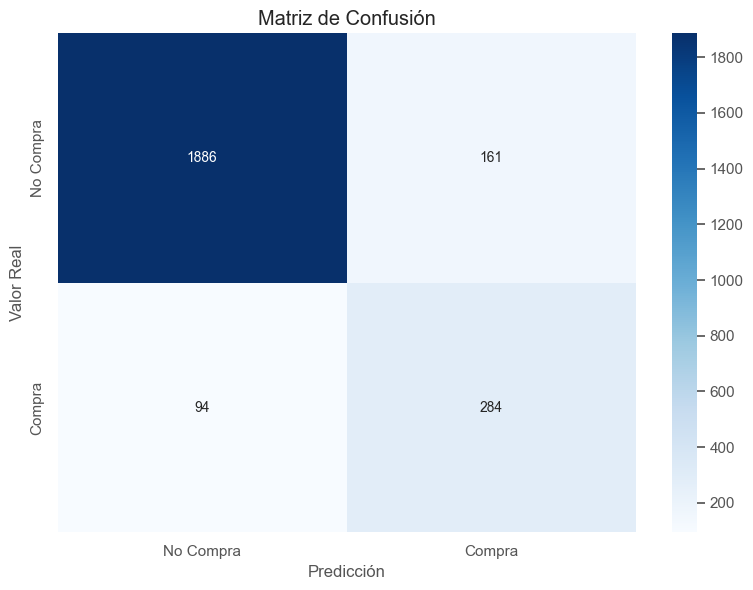

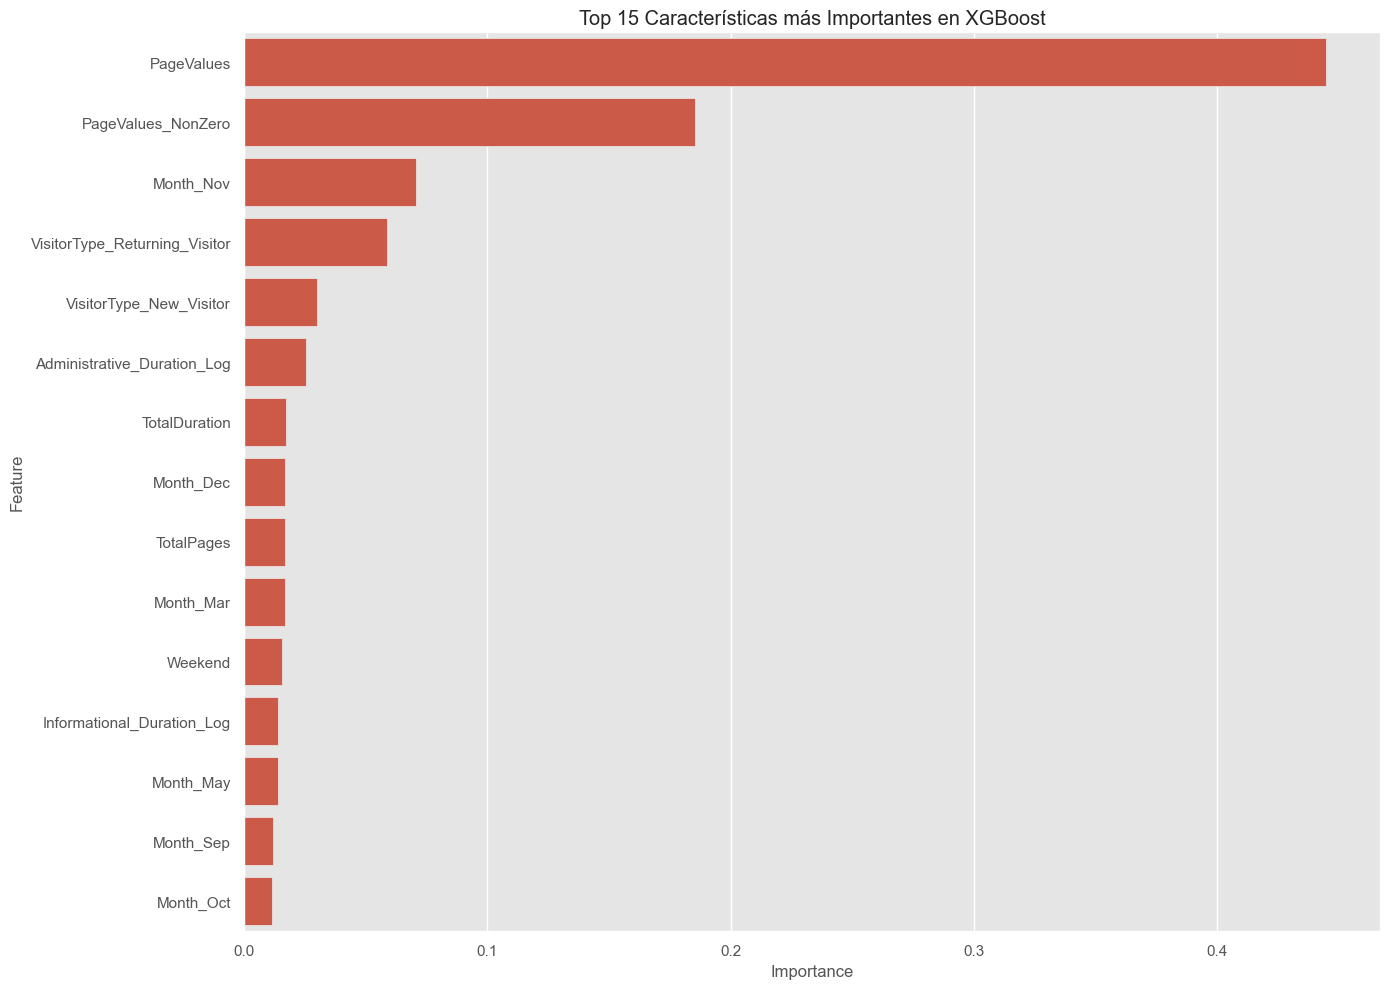

<Figure size 1200x800 with 0 Axes>

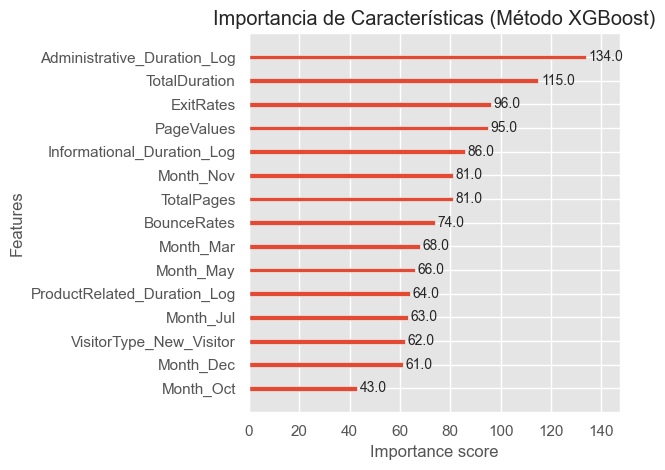

In [29]:
# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Compra', 'Compra'],
            yticklabels=['No Compra', 'Compra'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()

# Importancia de características
plt.figure(figsize=(14, 10))
# Obtener importance scores - para XGBoost podemos usar feature_importances_
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Mostrar las 15 características más importantes
top_features = feature_importance.head(15)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 15 Características más Importantes en XGBoost')
plt.tight_layout()
plt.show()

# También podemos visualizar con el método específico de XGBoost (requiere graphviz instalado)
try:
    from xgboost import plot_importance
    plt.figure(figsize=(12, 8))
    plot_importance(xgb_model, max_num_features=15)
    plt.title('Importancia de Características (Método XGBoost)')
    plt.tight_layout()
    plt.show()
except:
    print("No se pudo generar la visualización con plot_importance de XGBoost")

#### **4.3 Visualización de la Curva ROC**

<Figure size 800x600 with 0 Axes>

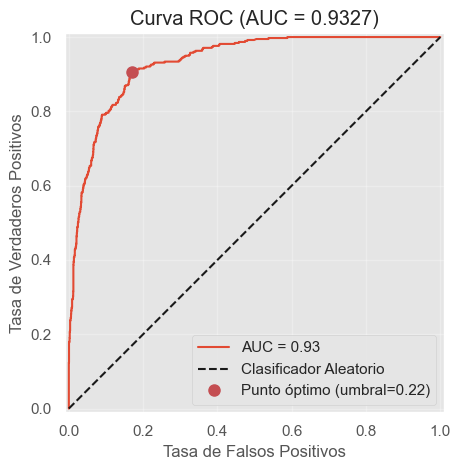

Umbral óptimo basado en la curva ROC: 0.2231
En este punto: FPR = 0.1710, TPR = 0.9048


In [30]:
# Generar la curva ROC
# Calcular y graficar la curva ROC
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_roc)
roc_display.plot()

# Añadir línea de referencia (clasificador aleatorio)
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio')

# Personalizar la gráfica
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title(f'Curva ROC (AUC = {auc_roc:.4f})')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Resaltar el punto de corte óptimo (ejemplo: maximizando la distancia a la línea diagonal)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=8, 
         label=f'Punto óptimo (umbral={optimal_threshold:.2f})')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

print(f"Umbral óptimo basado en la curva ROC: {optimal_threshold:.4f}")
print(f"En este punto: FPR = {fpr[optimal_idx]:.4f}, TPR = {tpr[optimal_idx]:.4f}")

#### **4.4 Visualización de la Curva Precision-Recall**

<Figure size 800x600 with 0 Axes>

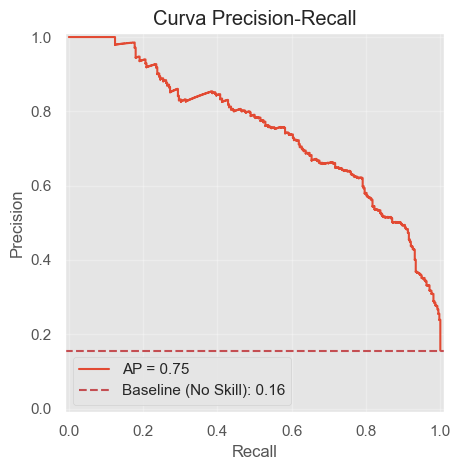

Average Precision Score: 0.7498
Línea base (proporción de clase positiva): 0.1559

## Conclusión:

XGBoost proporciona un poderoso modelo predictivo para identificar clientes potenciales en comercio electrónico.
Su capacidad para manejar datos desequilibrados, controlar el overfitting y capturar patrones complejos de comportamiento
lo convierten en una herramienta ideal para optimizar estrategias de marketing, personalizar la experiencia del usuario
y aumentar las conversiones en entornos de comercio online.


In [31]:
# Esta visualización es especialmente útil para datasets desbalanceados
plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
average_precision = average_precision_score(y_test, y_test_proba)

pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision)
pr_display.plot()

# Añadir línea de referencia (proporción de clase positiva)
baseline = np.sum(y_test) / len(y_test)
plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline (No Skill): {baseline:.2f}')

plt.title('Curva Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average Precision Score: {average_precision:.4f}")
print(f"Línea base (proporción de clase positiva): {baseline:.4f}")

print("\n## Conclusión:")
print("""
XGBoost proporciona un poderoso modelo predictivo para identificar clientes potenciales en comercio electrónico.
Su capacidad para manejar datos desequilibrados, controlar el overfitting y capturar patrones complejos de comportamiento
lo convierten en una herramienta ideal para optimizar estrategias de marketing, personalizar la experiencia del usuario
y aumentar las conversiones en entornos de comercio online.""")



#### Análisis de por qué XGBoost es ideal para este problema

In [32]:

print("\n## Por qué XGBoost es ideal para este problema de predicción de compras online:")
print("""
1. **Manejo superior de desequilibrio de clases**: XGBoost tiene un parámetro específico 'scale_pos_weight' para equilibrar 
   la clase minoritaria, complementando perfectamente el uso de SMOTE.

2. **Mejor control de overfitting**: Con múltiples parámetros de regularización (gamma, alpha, lambda), 
   XGBoost puede crear modelos más robustos en datos de comercio electrónico donde las señales de compra son sutiles.

3. **Mayor velocidad**: XGBoost utiliza computación paralela, lo que permite entrenamiento rápido incluso con 
   grandes volúmenes de datos de sesiones de navegación.

4. **Capacidad para capturar patrones complejos**: Los algoritmos de boosting secuencial capturan las relaciones no lineales 
   entre el comportamiento de navegación y la probabilidad de compra.

5. **Robustez frente a valores atípicos**: XGBoost es menos sensible a outliers, comunes en métricas 
   como duración de sesión o número de páginas vistas.

6. **Flexibilidad con variables categóricas y numéricas**: Maneja eficientemente tanto datos numéricos (duración, tasas) 
   como categóricos (tipo de visitante, mes).

7. **Transparencia interpretativa**: Proporciona métricas de importancia de características, cruciales para entender 
   qué factores impulsan las decisiones de compra.
""")




## Por qué XGBoost es ideal para este problema de predicción de compras online:

1. **Manejo superior de desequilibrio de clases**: XGBoost tiene un parámetro específico 'scale_pos_weight' para equilibrar 
   la clase minoritaria, complementando perfectamente el uso de SMOTE.

2. **Mejor control de overfitting**: Con múltiples parámetros de regularización (gamma, alpha, lambda), 
   XGBoost puede crear modelos más robustos en datos de comercio electrónico donde las señales de compra son sutiles.

3. **Mayor velocidad**: XGBoost utiliza computación paralela, lo que permite entrenamiento rápido incluso con 
   grandes volúmenes de datos de sesiones de navegación.

4. **Capacidad para capturar patrones complejos**: Los algoritmos de boosting secuencial capturan las relaciones no lineales 
   entre el comportamiento de navegación y la probabilidad de compra.

5. **Robustez frente a valores atípicos**: XGBoost es menos sensible a outliers, comunes en métricas 
   como duración de sesión o 